In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import json
from nltk import sent_tokenize
from tqdm import tqdm

tqdm.pandas()
# from transformers import pipeline

import seaborn as sns
from scipy.stats import norm

In [ ]:
data = pd.read_csv('../data/HI-CC_data.tsv',sep='\t')
# data['sentences'] = data['Full text'].progress_apply(sent_tokenize)

In [ ]:
data["Label"] = data["HI"].map({"yes": 'HI', "no": "Non-HI"})

In [27]:
data.groupby(['Label'])['index_id'].count()

Label
HI        2070
Non-HI    8230
Name: index_id, dtype: int64

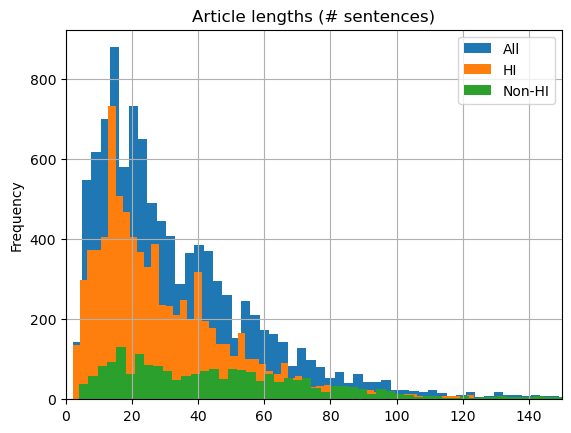

In [28]:
# len of hi vs non-hi

hi = data.Label == 'HI'

data.sentences.apply(len).plot.hist(bins=100,label='All')
data[~hi].sentences.apply(len).plot.hist(bins=100,label='HI')
data[hi].sentences.apply(len).plot.hist(bins=100,label='Non-HI')
plt.legend()
plt.xlim(0,150)
plt.title('Article lengths (# sentences)')
plt.grid()

In [43]:
# sentiment_analysis = pipeline("text-classification", 
#                               model="cardiffnlp/twitter-roberta-base-sentiment-latest", 
#                              top_k=None)
# data['sentiments'] = data['sentences'].progress_apply(sentiment_analysis)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
with open('../data/sentiment_data.json','rb') as f:
    datadict = json.load(f)
    
data = pd.DataFrame(datadict)

In [4]:
scores = data.iloc[0]['sentiments']
labels = []

for a in data.sentiments.values:
    tups = []
    for s in a:
        ldict = {}
        for l in s:
            ldict[l['label']] = l['score']
        tup = [ldict['negative'],ldict['neutral'],ldict['positive']]
        tups.append(tup)
    
    labels.append(tups) 

In [5]:
data['sentiment_scores'] = labels
data['sentiment_labels'] = [[int(np.argmax(t)) for t in l] for l in data.sentiment_scores]

In [6]:
data["sentiment_scores"][:4].values

array([list([[0.002001924905925989, 0.016421161592006683, 0.9815768599510193], [0.002930177142843604, 0.6542679071426392, 0.342801958322525], [0.007253630086779594, 0.7328572869300842, 0.25988906621932983], [0.0019871823024004698, 0.051544900983572006, 0.946467936038971], [0.006150676403194666, 0.42513349652290344, 0.5687158107757568], [0.006966596934944391, 0.36364948749542236, 0.6293838620185852], [0.04304547607898712, 0.9224600195884705, 0.03449452295899391], [0.08487234264612198, 0.8956401944160461, 0.019487565383315086], [0.8385827541351318, 0.15529200434684753, 0.006125295534729958], [0.01132181566208601, 0.515960156917572, 0.4727180004119873], [0.4307223856449127, 0.5402680039405823, 0.029009614139795303], [0.0028414418920874596, 0.7315104603767395, 0.26564809679985046], [0.0075172255747020245, 0.6885876655578613, 0.30389508605003357], [0.006714451126754284, 0.7465167045593262, 0.24676893651485443], [0.006646353751420975, 0.6535700559616089, 0.33978360891342163], [0.004872305784

In [7]:
def map_labels(tup):
    if np.argmax(tup) == 1: #neutral case
        score = 0
    elif np.argmax(tup) == 2: #pos case
        score = tup[2]
    else: # negative case
        score = -tup[0]
    return score

data['mapped_score'] = data['sentiment_scores'].apply(lambda x: [map_labels(s) for s in x])

In [8]:
# mean sentiment per article

data['average_sentiment'] = data['mapped_score'].apply(np.mean)

In [9]:
data['average_sentiment'].describe()

count    10300.000000
mean        -0.059011
std          0.198040
min         -0.871642
25%         -0.187411
50%         -0.070903
75%          0.043516
max          0.816336
Name: average_sentiment, dtype: float64

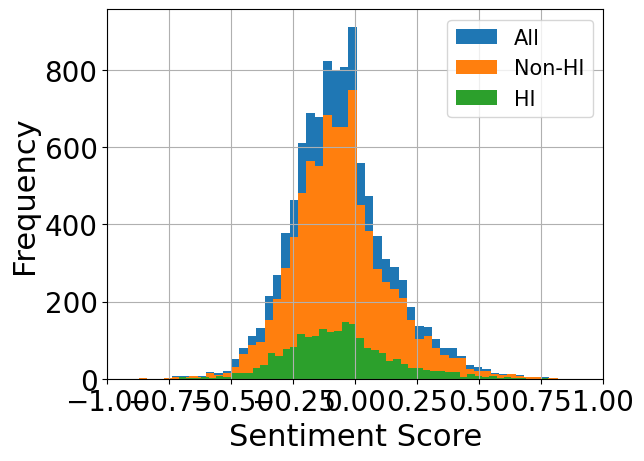

In [261]:
# len of hi vs non-hi

hi = data.Label == 'HI'

data.average_sentiment.plot.hist(bins=50,label='All',)
data[~hi].average_sentiment.plot.hist(bins=50,label='Non-HI')
data[hi].average_sentiment.plot.hist(bins=50,label='HI')
plt.legend(fontsize=15)
plt.ylabel("Frequency", fontsize=22)
plt.xlabel("Sentiment Score", fontsize=22)
plt.xlim(-1,1)
# _ = plt.title('Article avg sentiment', 
#               fontdict={'size': 18})
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
# plt.savefig("../docs/avg_sentiment.pdf",bbox_inches='tight')

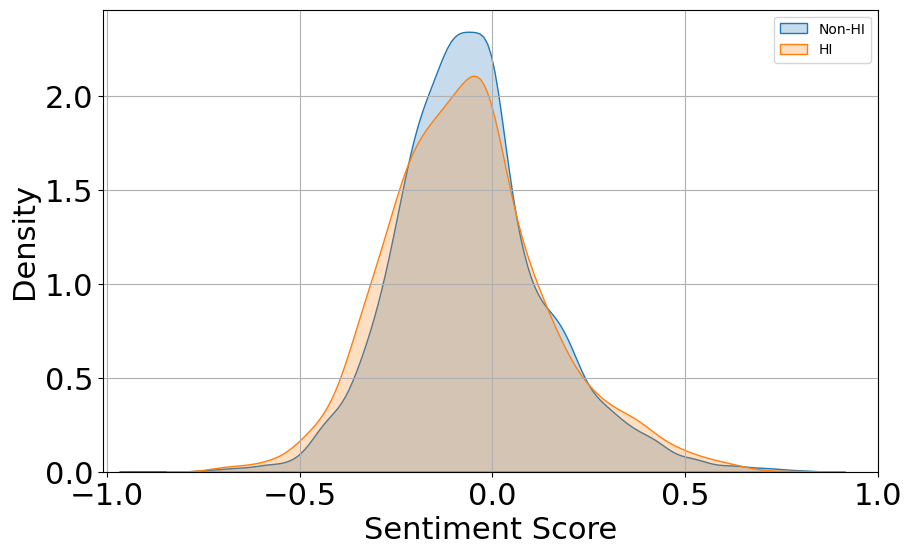

In [12]:
plt.figure(figsize=(10, 6))
hi = data.Label == 'HI'

# data.average_sentiment.plot.hist(bins=50,label='All',)
# data[~hi].average_sentiment.plot.hist(bins=50,label='Non-HI')
# data[hi].average_sentiment.plot.hist(bins=50,label='HI')

# sns.kdeplot(data[country].average_sentiment, fill=True, label='All')
sns.kdeplot(data[~hi].average_sentiment, fill=True, label='Non-HI', common_norm=False)
sns.kdeplot(data[hi].average_sentiment, fill=True, label='HI', common_norm=False)
plt.xlabel('Sentiment Score', fontdict={'size': 22})
plt.ylabel('Density', fontdict={'size': 22})
# plt.title('Sentiment Score Distribution for all Countries', fontdict={'size': 22})
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend()
plt.grid()
plt.xlim(-1.01,1)

# plt.savefig("../docs/kde_sentiment_All.pdf",bbox_inches='tight')
plt.show()

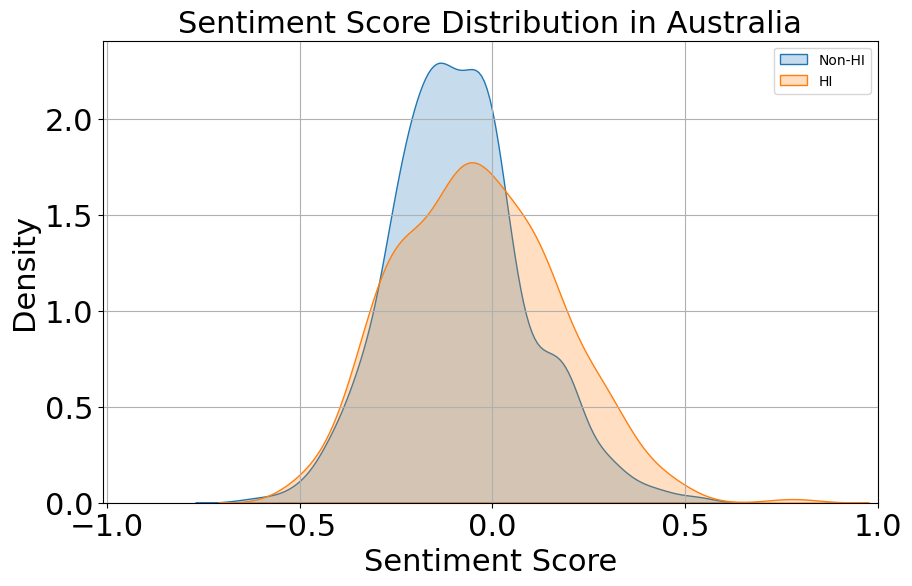

In [168]:


plt.figure(figsize=(10, 6))
hi_au = (data.Label == 'HI') & (data.Country == 'Australia')
non_hi_au = (data.Label == 'Non-HI') & (data.Country == 'Australia')
country = data.Country == 'Australia'

# sns.kdeplot(data[country].average_sentiment, fill=True, label='All')
sns.kdeplot(data[non_hi_au].average_sentiment, fill=True, label='Non-HI', common_norm=False)
sns.kdeplot(data[hi_au].average_sentiment, fill=True, label='HI', common_norm=False)

plt.xlabel('Sentiment Score', fontdict={'size': 22})
plt.ylabel('Density', fontdict={'size': 22})
plt.title('Sentiment Score Distribution in Australia', fontdict={'size': 22})
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.legend()
plt.grid()
plt.xlim(-1.01,1)
# plt.savefig("../docs/kde_sentiment_Australia.pdf",bbox_inches='tight')
plt.show()


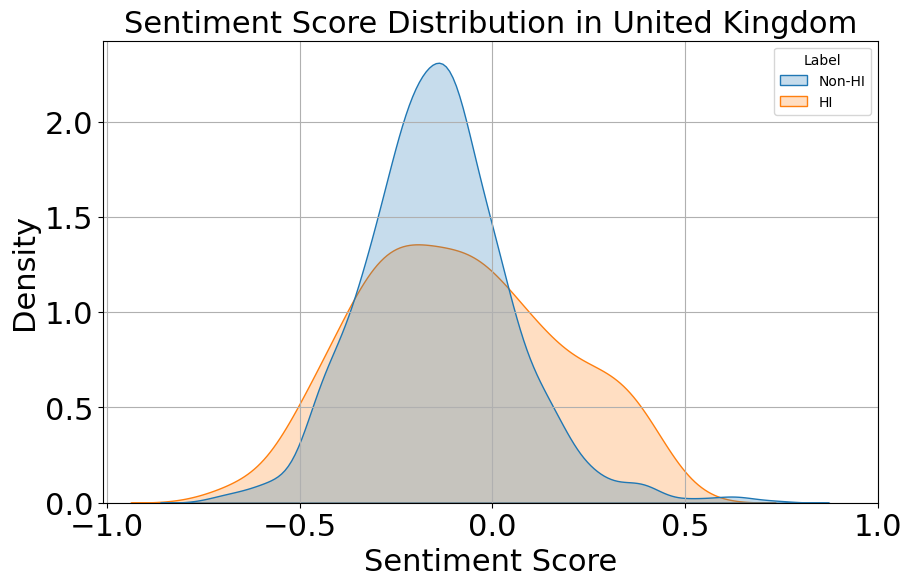

In [ ]:
plt.figure(figsize=(10, 6))
hi_country = (data.Label == 'HI') & (data.Country == 'United Kingdom')
non_hi_country = (data.Label == 'Non-HI') & (data.Country == 'United Kingdom')
country = data.Country == 'United Kingdom'

sns.kdeplot(x="average_sentiment", data=data[country], fill=True, hue="Label", common_norm=False)

plt.xlabel('Sentiment Score', fontdict={'size': 22})
plt.ylabel('Density', fontdict={'size': 22})
plt.title('Sentiment Score Distribution in United Kingdom', fontdict={'size': 22})
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
# plt.legend()
plt.grid()
plt.xlim(-1.01,1)
# plt.savefig("../docs/kde_sentiment_UK.pdf",bbox_inches='tight')
plt.show()


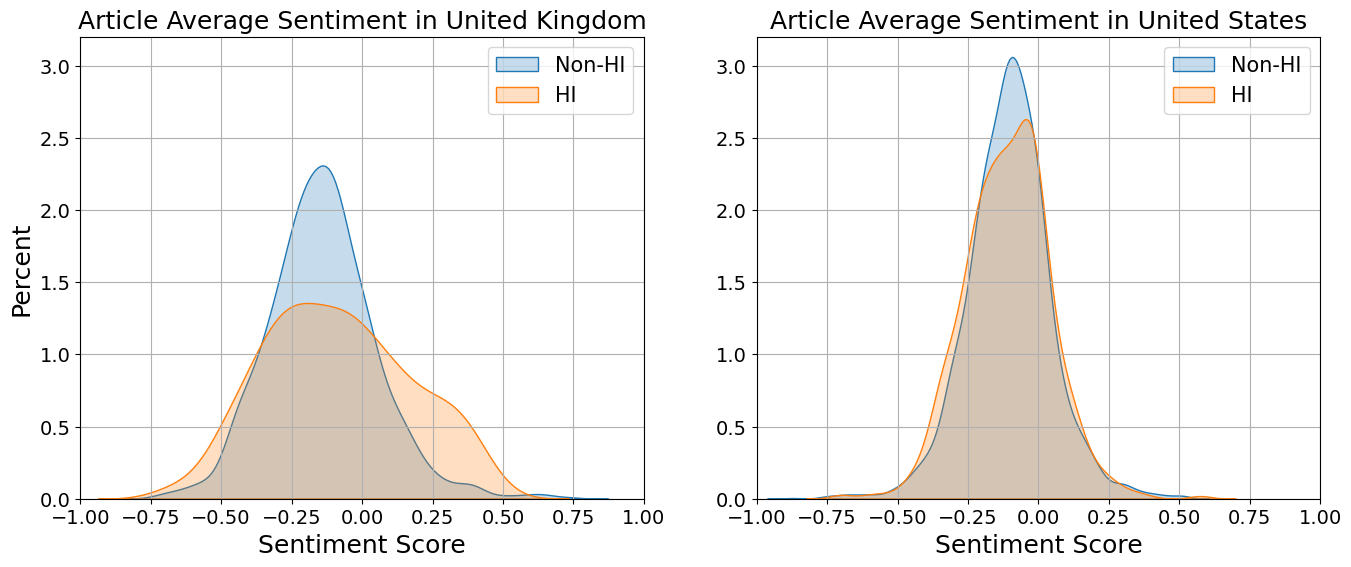

In [271]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# sns.kdeplot(x="average_sentiment", data=data[country], fill=True, hue="Label", common_norm=False)
sns.kdeplot(data[uk_non_hi_country].average_sentiment, label='Non-HI', fill=True, ax=axs[0])
sns.kdeplot(data[uk_hi_country].average_sentiment, label='HI', fill=True,  ax=axs[0])
axs[0].set_ylim(0,3.2)
axs[0].legend(fontsize=15)
axs[0].set_xlim(-1,1)
axs[0].set_title(f"Article Average Sentiment in United Kingdom", fontsize=18)
axs[0].set_ylabel("Percent", fontsize=20)
axs[0].set_xlabel("Sentiment Score", fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid()

sns.kdeplot(data[us_non_hi_country].average_sentiment, label='Non-HI', fill=True, ax=axs[1])
sns.kdeplot(data[us_hi_country].average_sentiment, label='HI', fill=True,  ax=axs[1])
axs[1].set_ylim(0,3.2)
axs[1].legend(fontsize=15)
axs[1].set_xlim(-1,1)
axs[1].set_title(f"Article Average Sentiment in United States", fontsize=18)
axs[1].set_ylabel(" ", fontsize=20)
axs[1].set_xlabel("Sentiment Score", fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid()
# axs[1].set_yticklabels([])

# plt.savefig(f"../docs/avg_sentiment_{country}.pdf",bbox_inches='tight')
plt.show()